In [3]:
import os
import re
import glob
import xarray as xr
import numpy as np
from pathlib import Path
from typing import Union, Optional, Callable
from tqdm import tqdm
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster, progress
import cmcrameri.cm as cmc

In [4]:
data_dir = "/scratch/opodriscoll/data/ERA5"

def preprocess_drop_coord(ds: xr.Dataset, coord_to_drop: str|list[str] = ["expver", "surface"]):
    return ds.drop_vars(coord_to_drop, errors='ignore')

## Open .zarr files 

In [6]:
temperature_files = glob.glob(str(data_dir) + "/*02?_temperature.zarr") # for temperature at pressure levels specifically
humidity_files = glob.glob(str(data_dir) + "/*02?_relative_humidity.zarr") # for relative humidity at pressure levels specifically

list_files = glob.glob(str(data_dir) + "/*.zarr")
list_files = temperature_files + humidity_files 

# Optionally, remove duplicates if needed
list_files = list(set(list_files))
list_files.sort()
list_files

['/scratch/opodriscoll/data/ERA5/2020_relative_humidity.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_temperature.zarr',
 '/scratch/opodriscoll/data/ERA5/2021_relative_humidity.zarr',
 '/scratch/opodriscoll/data/ERA5/2021_temperature.zarr']

In [7]:
ds = xr.open_mfdataset(list_files, engine="zarr", preprocess=preprocess_drop_coord)

## Compute Lower Tropospheric Stability (LTS) and Estimated Inversion Strength (EIS) from ERA5 pressure levels

In [10]:
from CMOD_analysis.atmosphere import estimated_inversion_strength, calculate_LTS
import pandas as pd

In [11]:
RH_700 =ds['r'].sel(pressure_level = 700)
T_700 = ds['t'].sel(pressure_level = 700)
T_850 = ds['t'].sel(pressure_level = 850)
T_925 = ds['t'].sel(pressure_level = 925)
T_sfc = ds['sst']
z0 = 0
RH = 0.8 # this is an approximate, following Wood and Bretherton 2006

EIS = estimated_inversion_strength(
    T_700=T_700, 
    T_850=T_850, 
    T_925=T_925, 
    T_sfc=T_sfc, 
    z=z0, 
    RH=RH,
    method = 'wood',
)

LTS = calculate_LTS(T_700, T_sfc)

ds[['EIS', 'LTS', 'RH_700']] = EIS, LTS, RH_700
ds_coarse = ds[['EIS', 'LTS', 'RH_700']].coarsen(dict(longitude=16, latitude=16), boundary='pad').mean()

In [12]:
ds_coarse.coords['monthhour'] = (
    ('valid_time', ),
    pd.MultiIndex.from_arrays([ds_coarse.valid_time.dt.month.data, ds_coarse.valid_time.dt.hour.data])
)

ds_coarse_avg = ds_coarse.groupby('monthhour').mean(dim='valid_time').unstack('monthhour')
ds_coarse_std = ds_coarse.groupby('monthhour').std(dim='valid_time').unstack('monthhour')

In [13]:
ds_coarse_avg

<xarray.Dataset> Size: 15MB
Dimensions:             (valid_time_level_0: 12, valid_time_level_1: 24,
                         latitude: 36, longitude: 90)
Coordinates:
  * valid_time_level_0  (valid_time_level_0) int64 96B 1 2 3 4 5 ... 9 10 11 12
  * valid_time_level_1  (valid_time_level_1) int64 192B 0 1 2 3 ... 20 21 22 23
  * latitude            (latitude) float64 288B 68.12 64.12 ... -67.88 -70.0
  * longitude           (longitude) float64 720B -178.1 -174.1 ... 173.9 177.9
    number              int64 8B 0
Data variables:
    EIS                 (latitude, longitude, valid_time_level_0, valid_time_level_1) float64 7MB dask.array<chunksize=(12, 12, 1, 1), meta=np.ndarray>
    LTS                 (latitude, longitude, valid_time_level_0, valid_time_level_1) float32 4MB dask.array<chunksize=(12, 12, 1, 1), meta=np.ndarray>
    RH_700              (latitude, longitude, valid_time_level_0, valid_time_level_1) float32 4MB dask.array<chunksize=(12, 12, 1, 1), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-10-09T17:56 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

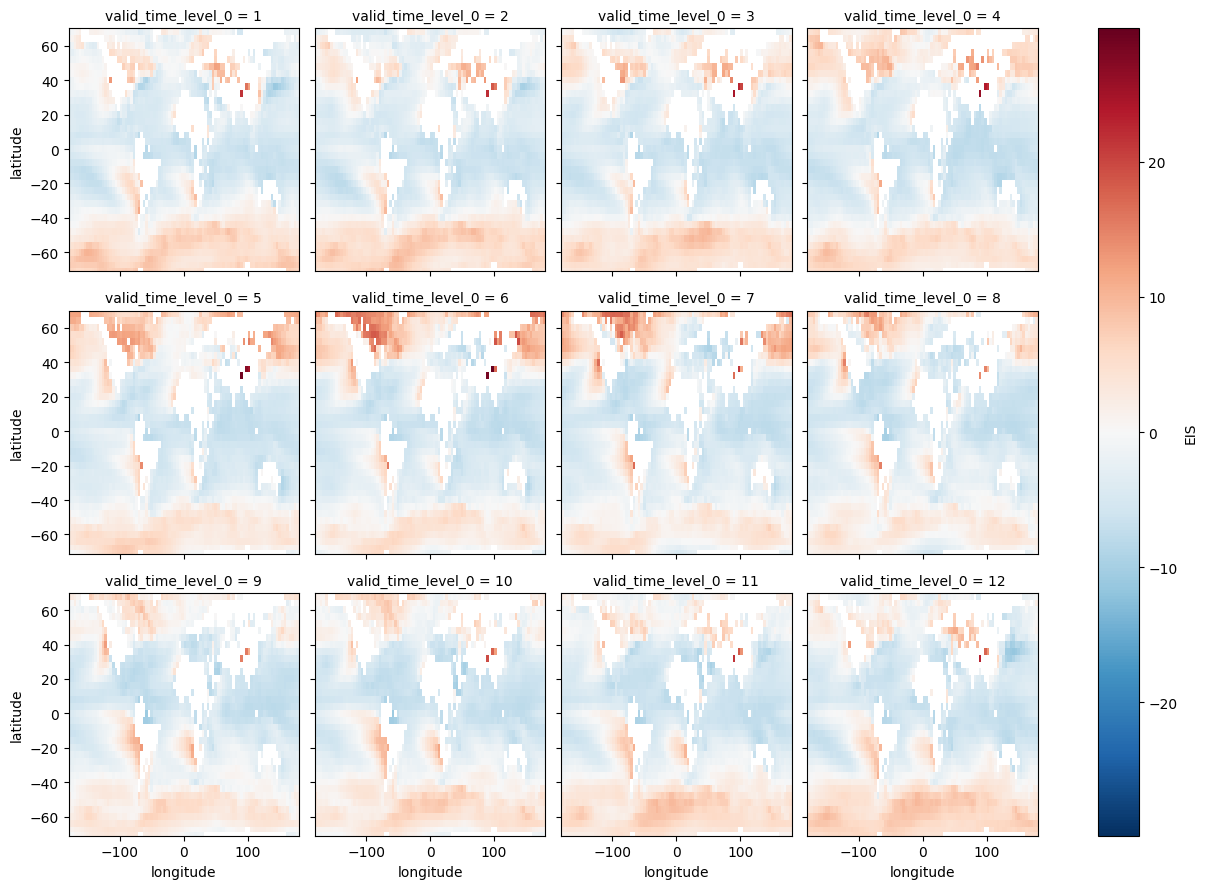

In [28]:
ds_coarse_avg.sel(valid_time_level_1 = 6)['EIS'].plot(x="longitude", y="latitude", col="valid_time_level_0", col_wrap=4) 

## Co-locate with dataframe points

In [14]:
file_name = "/scratch/opodriscoll/data/Sentinel-1/dataframes/df_w_highres_latent.csv"
df = pd.read_csv(file_name)
df.head(5)

,Unnamed: 0,index,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,...,median_75th,std_75th,mad_75th,S_windfield_xi_mean,S_windfield_xi_norm_std,S_sigma0_xi_mean,S_sigma0_xi_norm_std,inertial_subrange_length,energy_dir_range,slhf_highres
0,0,43,44,wv2,-101.826509085 -25.6805796738,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.634714,WS,...,62.0,60.758867,46.0,0.001682,0.352548,7.426597e-08,0.359761,2299.399624,51.5,-248.343156
1,1,2,3,wv1,157.487679483 46.6362002612,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.525564,AF,...,68.5,46.749110,45.5,0.000304,0.203705,1.649799e-07,0.200994,2523.062585,29.5,-7.299904
2,2,103,104,wv2,-126.149245849 24.9142669613,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.992728,OF,...,60.0,93.193627,51.0,0.001938,0.314485,1.243485e-07,0.315330,2468.989533,36.5,-188.296463
3,3,81,82,wv2,-151.467738318 7.75917557303,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.690646,OF,...,69.0,49.464820,41.0,0.000608,0.235655,7.722955e-09,0.239126,1056.764370,33.5,-108.323471
4,4,19,20,wv2,156.450687878 35.3909018142,/home/datawork-cersat-public/cache/public/ftp/...,OK,MCC,0.674053,SI,...,19.0,72.127456,19.0,0.005072,0.171388,2.604131e-07,0.149163,2608.300898,26.0,-345.934569


In [15]:
# Get the corresponding coordinate values
timestamp = pd.to_datetime(df['datetime_imagette'])
valid_month = timestamp.dt.month.values
valid_hour = timestamp.dt.round('h').dt.hour
latitudes = df['lat_sar'].values#
longitudes = df['lon_sar'].values#

In [16]:
p = ds_coarse_avg.sel(
    valid_time_level_0=xr.DataArray(valid_month, dims='points'),
    valid_time_level_1=xr.DataArray(valid_hour, dims='points'),
    latitude=xr.DataArray(latitudes, dims='points'),
    longitude=xr.DataArray(longitudes, dims='points'),
    method='nearest'
).compute()
p

<xarray.Dataset> Size: 14MB
Dimensions:             (points: 249496)
Coordinates:
    valid_time_level_0  (points) int64 2MB 8 5 2 8 4 9 8 7 ... 12 11 2 7 8 6 8 4
    valid_time_level_1  (points) int64 2MB 12 20 2 4 20 21 ... 13 2 9 18 18 17
    latitude            (points) float64 2MB -23.88 48.12 ... -31.88 -15.88
    longitude           (points) float64 2MB -102.1 157.9 ... 173.9 -170.1
    number              int64 8B 0
  * points              (points) int64 2MB 0 1 2 3 ... 249493 249494 249495
Data variables:
    EIS                 (points) float64 2MB -0.7363 9.884 ... -4.359 -7.091
    LTS                 (points) float32 998kB -15.07 -8.945 ... -19.85 -19.6
    RH_700              (points) float32 998kB 9.351 57.67 24.59 ... 29.7 57.81
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-10-09T17:56 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [18]:
df[['EIS', 'LTS', 'RH_700']] = p.to_dataframe()[['EIS', 'LTS', 'RH_700']]

In [19]:
df.to_csv("/scratch/opodriscoll/data/Sentinel-1/dataframes/df_w_highres_latent_lowres_EIS_LTS_RH_700.csv", index = False)